# **DS5220 Supervised Machine Learning and Learning Theory: Project**

Name: **DANISH MANSOOR**\
Program: **PhD (Interdisciplinary Engineering)**\
Department: **CIVIL & ENVIRONMENTAL ENGINEERING**\
Email ID: **mansoor.d@northeastern.edu**\
NUID: **002209538**


# **Statistical Downscaling of Climate Data Using Deep Learning (ConvLSTM)**

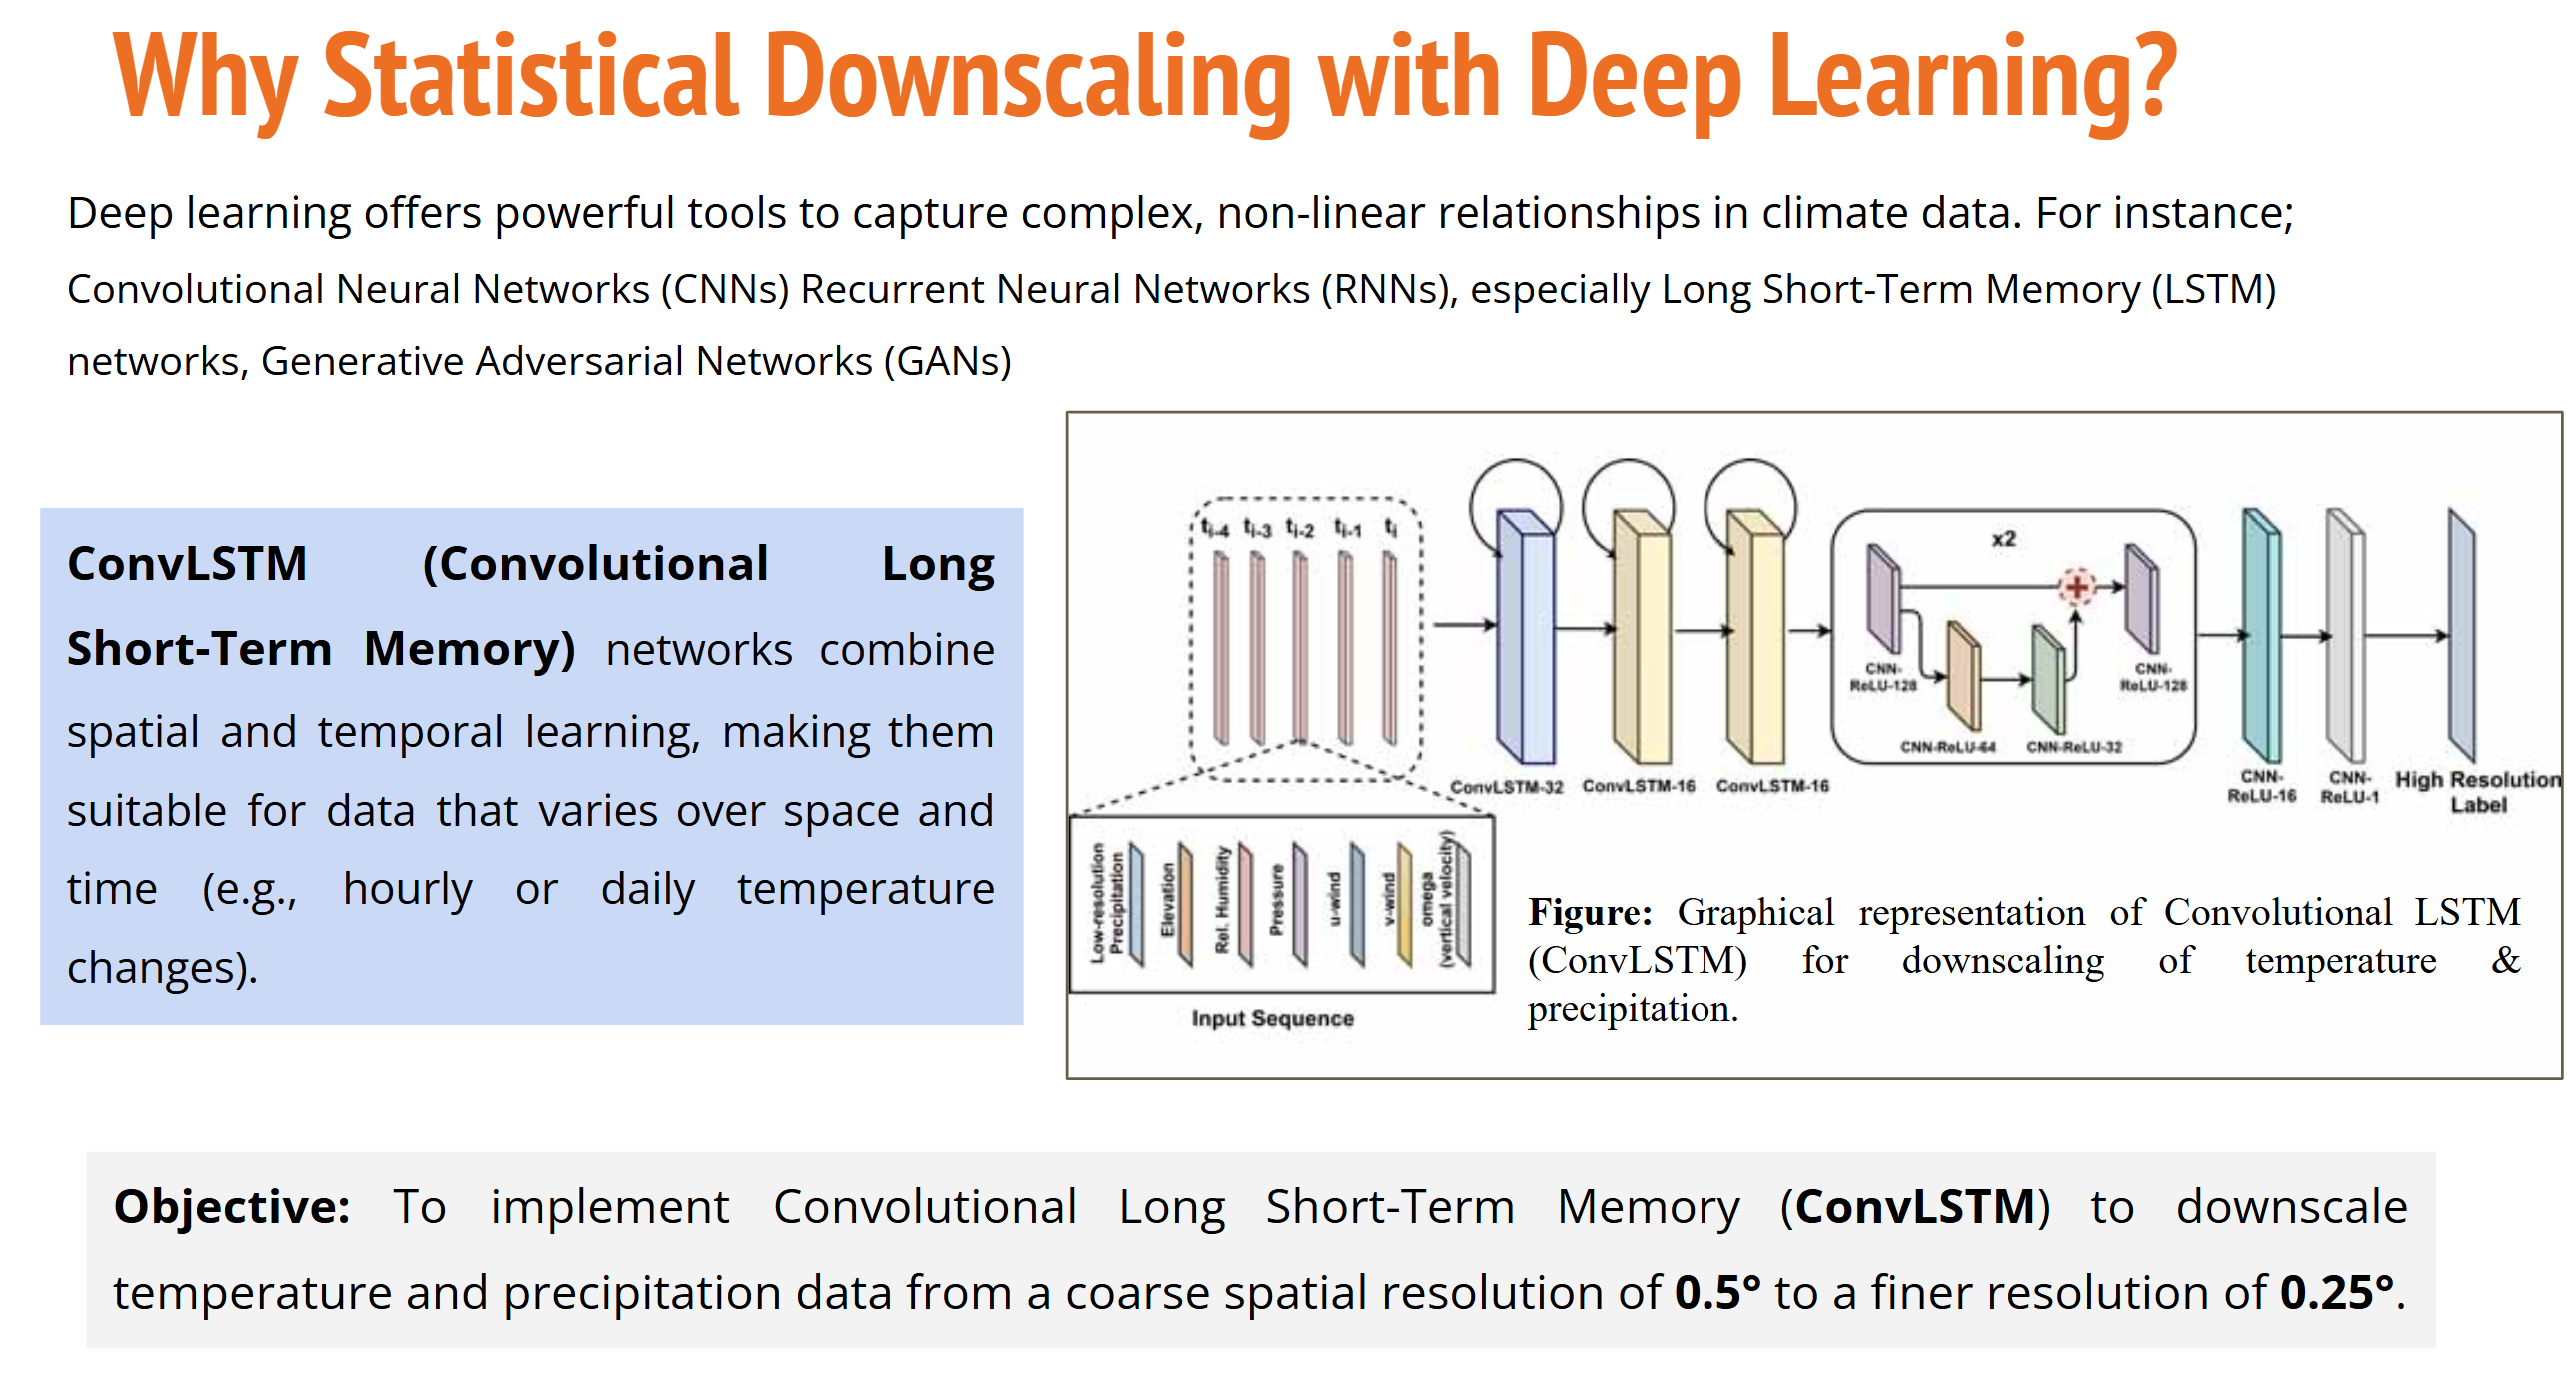

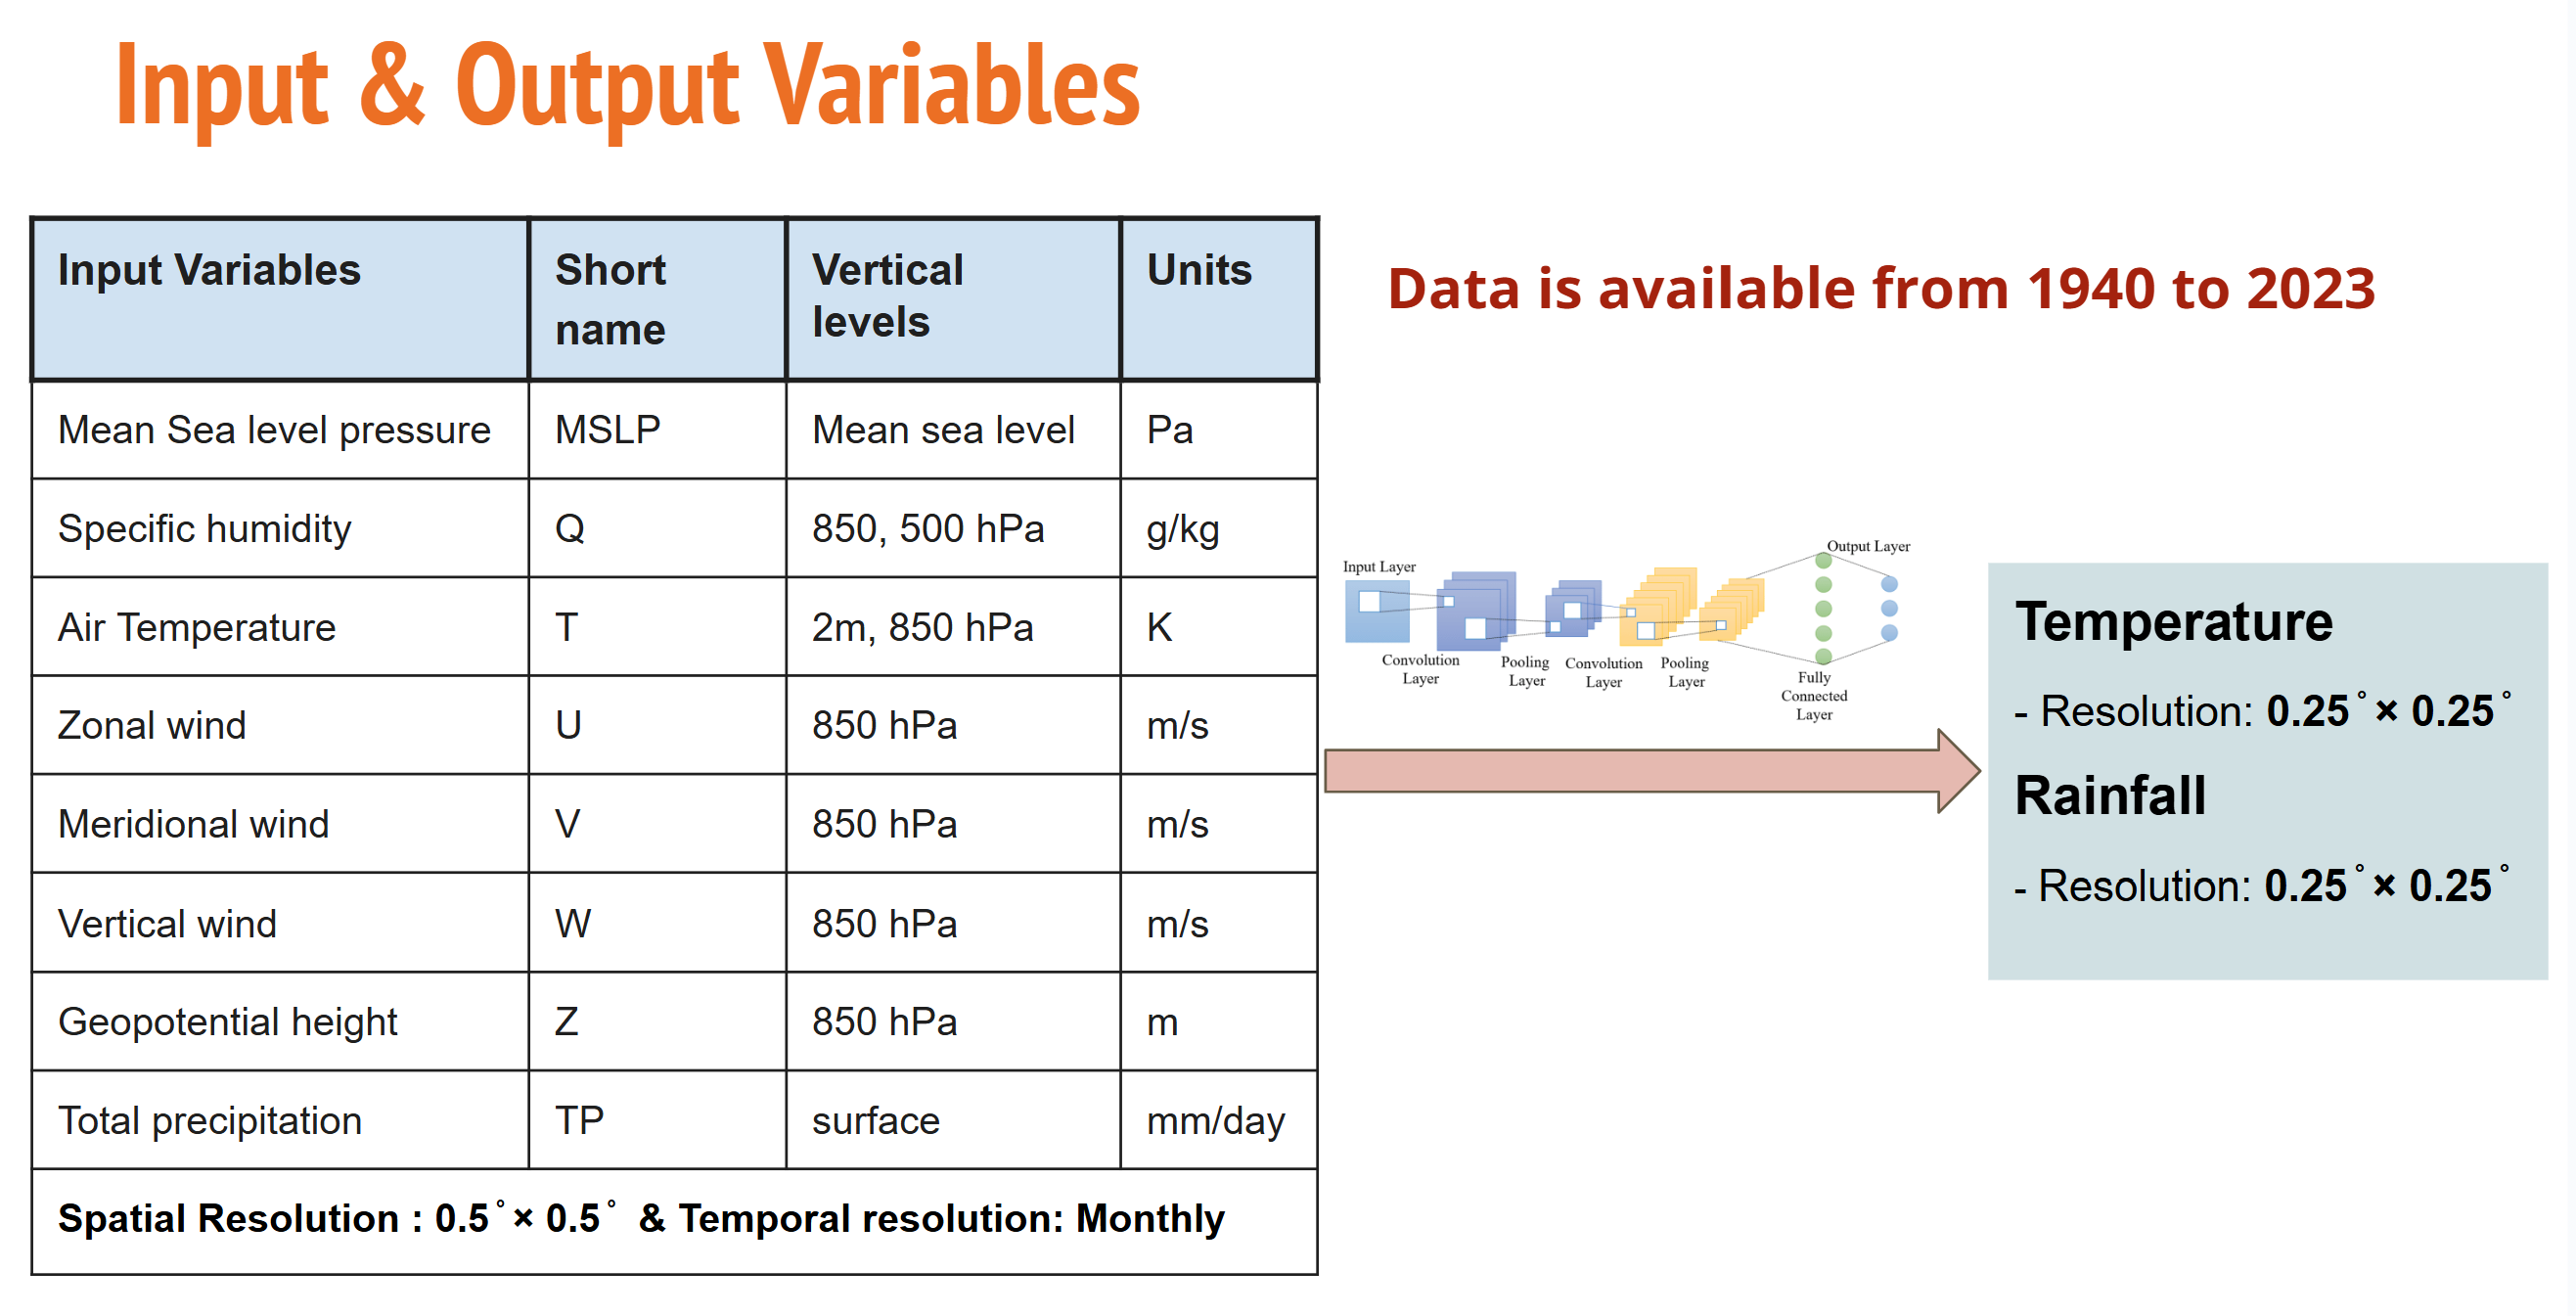

# **Library**

In [ ]:
# !pip install pytorch-msssim

In [ ]:
# import cftime
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy.integrate as inte
from scipy.stats import shapiro
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

from pytorch_msssim import ssim
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import imageio

**All the data will be given in the github**

In [ ]:
pathx='/content/drive/MyDrive/03_Downscaling_Work'
os.chdir(pathx)
!ls

# **Downscaling of Temperature**

## **Data loading and Stacking**

In [ ]:
# Load upscaled and original datasets
Input_data = xr.open_dataset('Interpolated_from_0.5_0.25_to_fine.nc') # 0.5 degree
Input_dataX=Input_data.sel(lat=slice(26,19.5),lon=slice(73,83))
Target_data = xr.open_dataset('Input_downscaling_data_Central_India_1940_2023.nc') # 0.25 degree
Target_dataX=Target_data.sel(lat=slice(26,19.5),lon=slice(73,83))

X_variables = ['MSLP', 'Specific_Humidity_850', 'Specific_Humidity_500', 'Air_Temperature_2m', 'Air_Temperature_850', 'Zonal_Wind_850', 'Meridional_Wind_850', 'Vertical_Wind_850', 'Geopotential_Height_850','Total_Precipitation']

target_variable = 'Air_Temperature_2m'


#---------------------
# Extract the data for each variable
extracted_data = [Input_dataX [var].values for var in X_variables]

# Stack the variables along the last axis (this creates an array of shape (time, lat, lon, num_variables))
stacked_data = np.stack(extracted_data, axis=-1)

# Reorder the axes to match the desired shape: [time, variable, lat, lon]
reformatted_data = np.moveaxis(stacked_data, (0, 1, 2, 3), (0, 2, 3, 1))
Input_tensor = torch.tensor(reformatted_data, dtype=torch.float32)
print(f"PyTorch Tensor shape: {Input_tensor.shape}")

#------------------------------------------------------------------------------------------------------------

extracted_data = Target_dataX[target_variable ].values  # Extract the values for the variable
# Transpose the dimensions to [lat, lon, time]
transposed_data = np.transpose(extracted_data, (0,1,2))
# Add a new dimension for the variable, resulting in [lat, lon, time, variables]
reshaped_data = np.expand_dims(transposed_data, axis=1)


# Convert to PyTorch tensor
Target_tensor = torch.tensor(reshaped_data, dtype=torch.float32)

# Verify the tensor shape
print(f"Tensor shape: {Target_tensor.shape}")  # Should be [47, 31, 1008, 1]

PyTorch Tensor shape: torch.Size([1008, 10, 27, 41])
Tensor shape: torch.Size([1008, 1, 27, 41])


In [ ]:
#------------------------Data Preparation-----------------------------------------------
def prepare_data(low_res_data, high_res_data, time_steps, batch_size):
    """
    Prepares normalized data for training, validation, and testing.
    """
    # Compute mean and std for each variable in the low-res dataset
    means = low_res_data.mean(axis=(0, 2, 3))
    stds = low_res_data.std(axis=(0, 2, 3))

    # Normalize low-res data
    low_res_data = (low_res_data - means[None, :, None, None]) / stds[None, :, None, None]

    # Normalize high-res data (if required)
    high_res_mean = high_res_data.mean()
    high_res_std = high_res_data.std()
    high_res_data = (high_res_data - high_res_mean) / high_res_std

    # Validate divisibility by time steps
    num_samples = low_res_data.shape[0]
    if num_samples % time_steps != 0:
        num_samples = num_samples // time_steps * time_steps  # Truncate extra samples

    # Reshape for temporal modeling
    low_res_data = low_res_data[:num_samples].view(-1, time_steps, 10, 27,41)
    high_res_data = high_res_data[:num_samples].view(-1, time_steps, 1, 27,41)

    # Create dataset
    dataset = TensorDataset(low_res_data, high_res_data)

    # Split into train, validation, and test sets
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, means, stds, high_res_mean, high_res_std

## **Temperature ConvLSTM**

In [ ]:
# -------------------ConvLSTM Model-------------------
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm_cells = nn.ModuleList([
            nn.Conv2d(input_dim if i == 0 else hidden_dim,
                      hidden_dim,
                      kernel_size=kernel_size,
                      padding=kernel_size // 2)
            for i in range(num_layers)
        ])

        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.shape
        h, c = [torch.zeros(batch_size, self.hidden_dim, height, width).to(x.device) for _ in range(2)]

        for t in range(time_steps):
            cur_input = x[:, t]
            for i, lstm_cell in enumerate(self.lstm_cells):
                h_next = torch.tanh(lstm_cell(cur_input)) + c
                h_next = self.dropout(h_next)  # Dropout
                c = h_next  # Update cell state
                cur_input = h_next

        # Output layer for the last time step
        output = self.conv_out(cur_input)
        return output

# -------------------
# Loss Functions
# -------------------
def combined_loss(output, target, alpha=0.8):
    """
    Combines MSE Loss and SSIM Loss.
    """
    mse_loss = nn.MSELoss()(output, target)
    ssim_loss = 1 - ssim(output, target, data_range=1.0)
    return alpha * mse_loss + (1 - alpha) * ssim_loss

# -------------------
# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs):
    model.train()

    # Initialize lists to store losses
    L1 = []  # To store training loss for each epoch
    L2 = []  # To store validation loss for each epoch

    for epoch in range(epochs):
        train_loss = 0.0
        for low_res_batch, high_res_batch in train_loader:
            low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(low_res_batch)

            # Compute loss
            target = high_res_batch[:, -1, :, :, :]
            loss = combined_loss(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        Ls_train = train_loss / len(train_loader)
        L1.append(Ls_train)

        # Scheduler step
        scheduler.step()

        # Validation
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for low_res_batch, high_res_batch in val_loader:
                low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)
                output = model(low_res_batch)
                target = high_res_batch[:, -1, :, :, :]
                val_loss += combined_loss(output, target).item()

        # Calculate average validation loss for the epoch
        Ls_val = val_loss / len(val_loader)
        L2.append(Ls_val)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {Ls_train:.4f}, Val Loss: {Ls_val:.4f}")

    return model, L1, L2


low_res_data=Input_tensor
high_res_data=Target_tensor
# Main
# -------------------

if __name__ == "__main__":
    # Example synthetic data
    low_res_data = Input_tensor
    high_res_data = Target_tensor
#-------------------------------------Final Parameters------------------------------
    time_steps = 3
    batch_size = 32
    epochs = 60
    learning_rate = 0.001

    # Prepare data
    train_loader, val_loader, test_loader,means, stds, high_res_mean, high_res_std  = prepare_data(low_res_data, high_res_data, time_steps, batch_size) #----------------------------------

    # Model
    model = ConvLSTM(input_dim=10, hidden_dim=64, kernel_size=3, num_layers=3).to(device)

    # Optimizer and Scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Train the model
    trained_model,Ls,Lv = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs)

In [ ]:
plt.figure(figsize=(12, 8),dpi=200)
plt.plot(Ls[1:], label='Training Loss')
plt.plot(Lv[1:], label='Validation Loss')
plt.xlabel('Epoch',fontsize='14',weight='bold')
plt.ylabel('Loss',fontsize='14',weight='bold')
# plt.title('Training and Validation Loss',fontsize='20',weight='bold',)
plt.grid(color='gray',linestyle='--')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Get the current axes
ax = plt.gca()

# Set the font weight of the tick labels to bold
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.show()

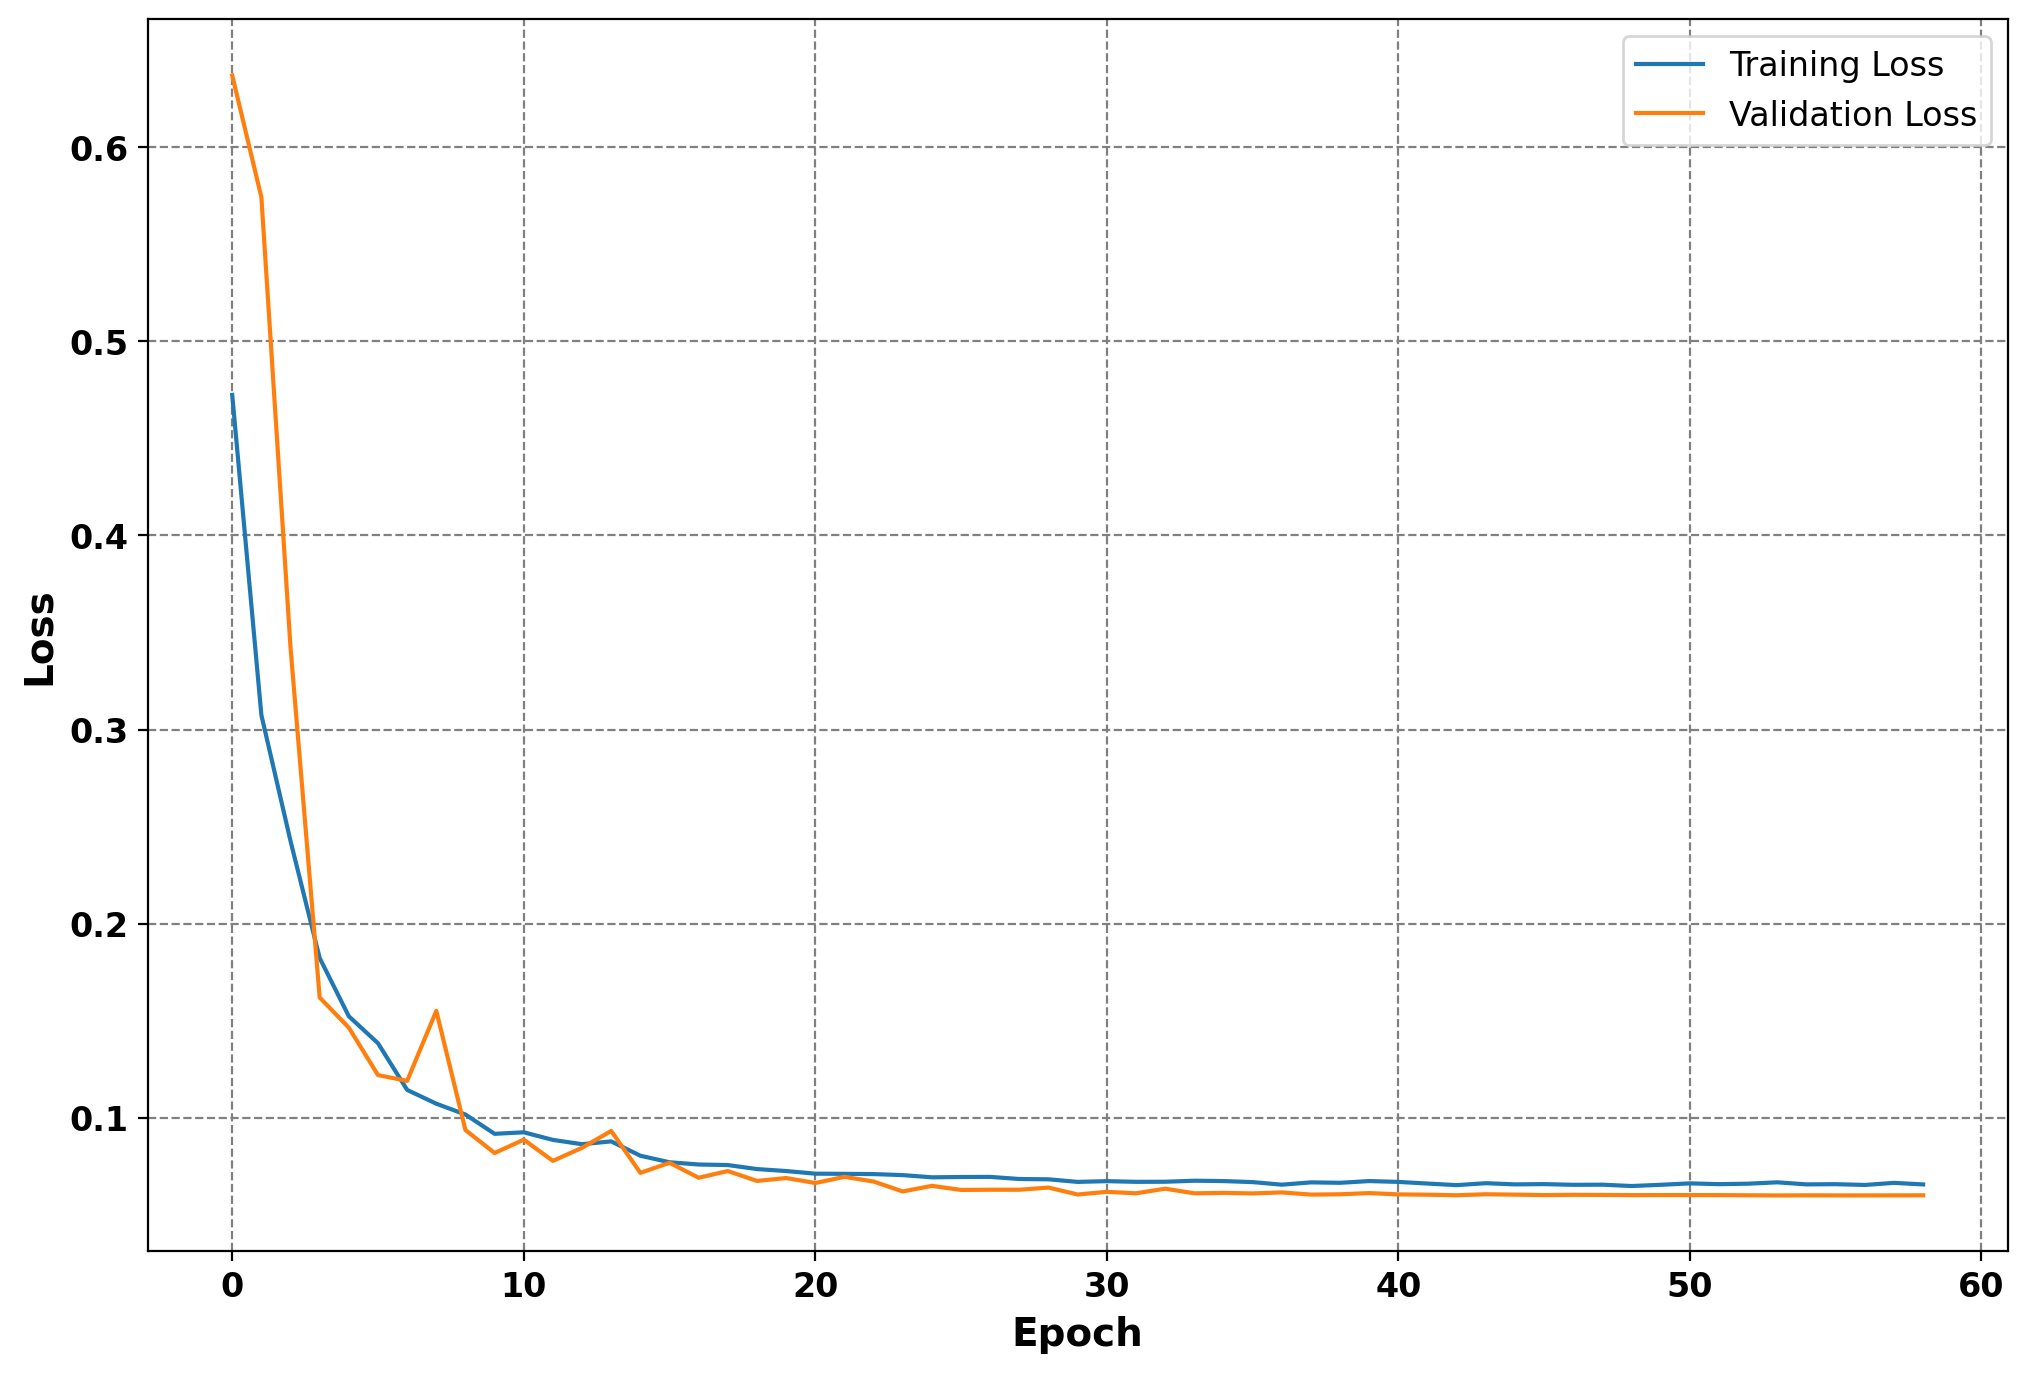

## **Visualization of Testing Data**

Shape of denormalized_output: torch.Size([32, 27, 41])
Shape of denormalized_target: torch.Size([32, 27, 41])


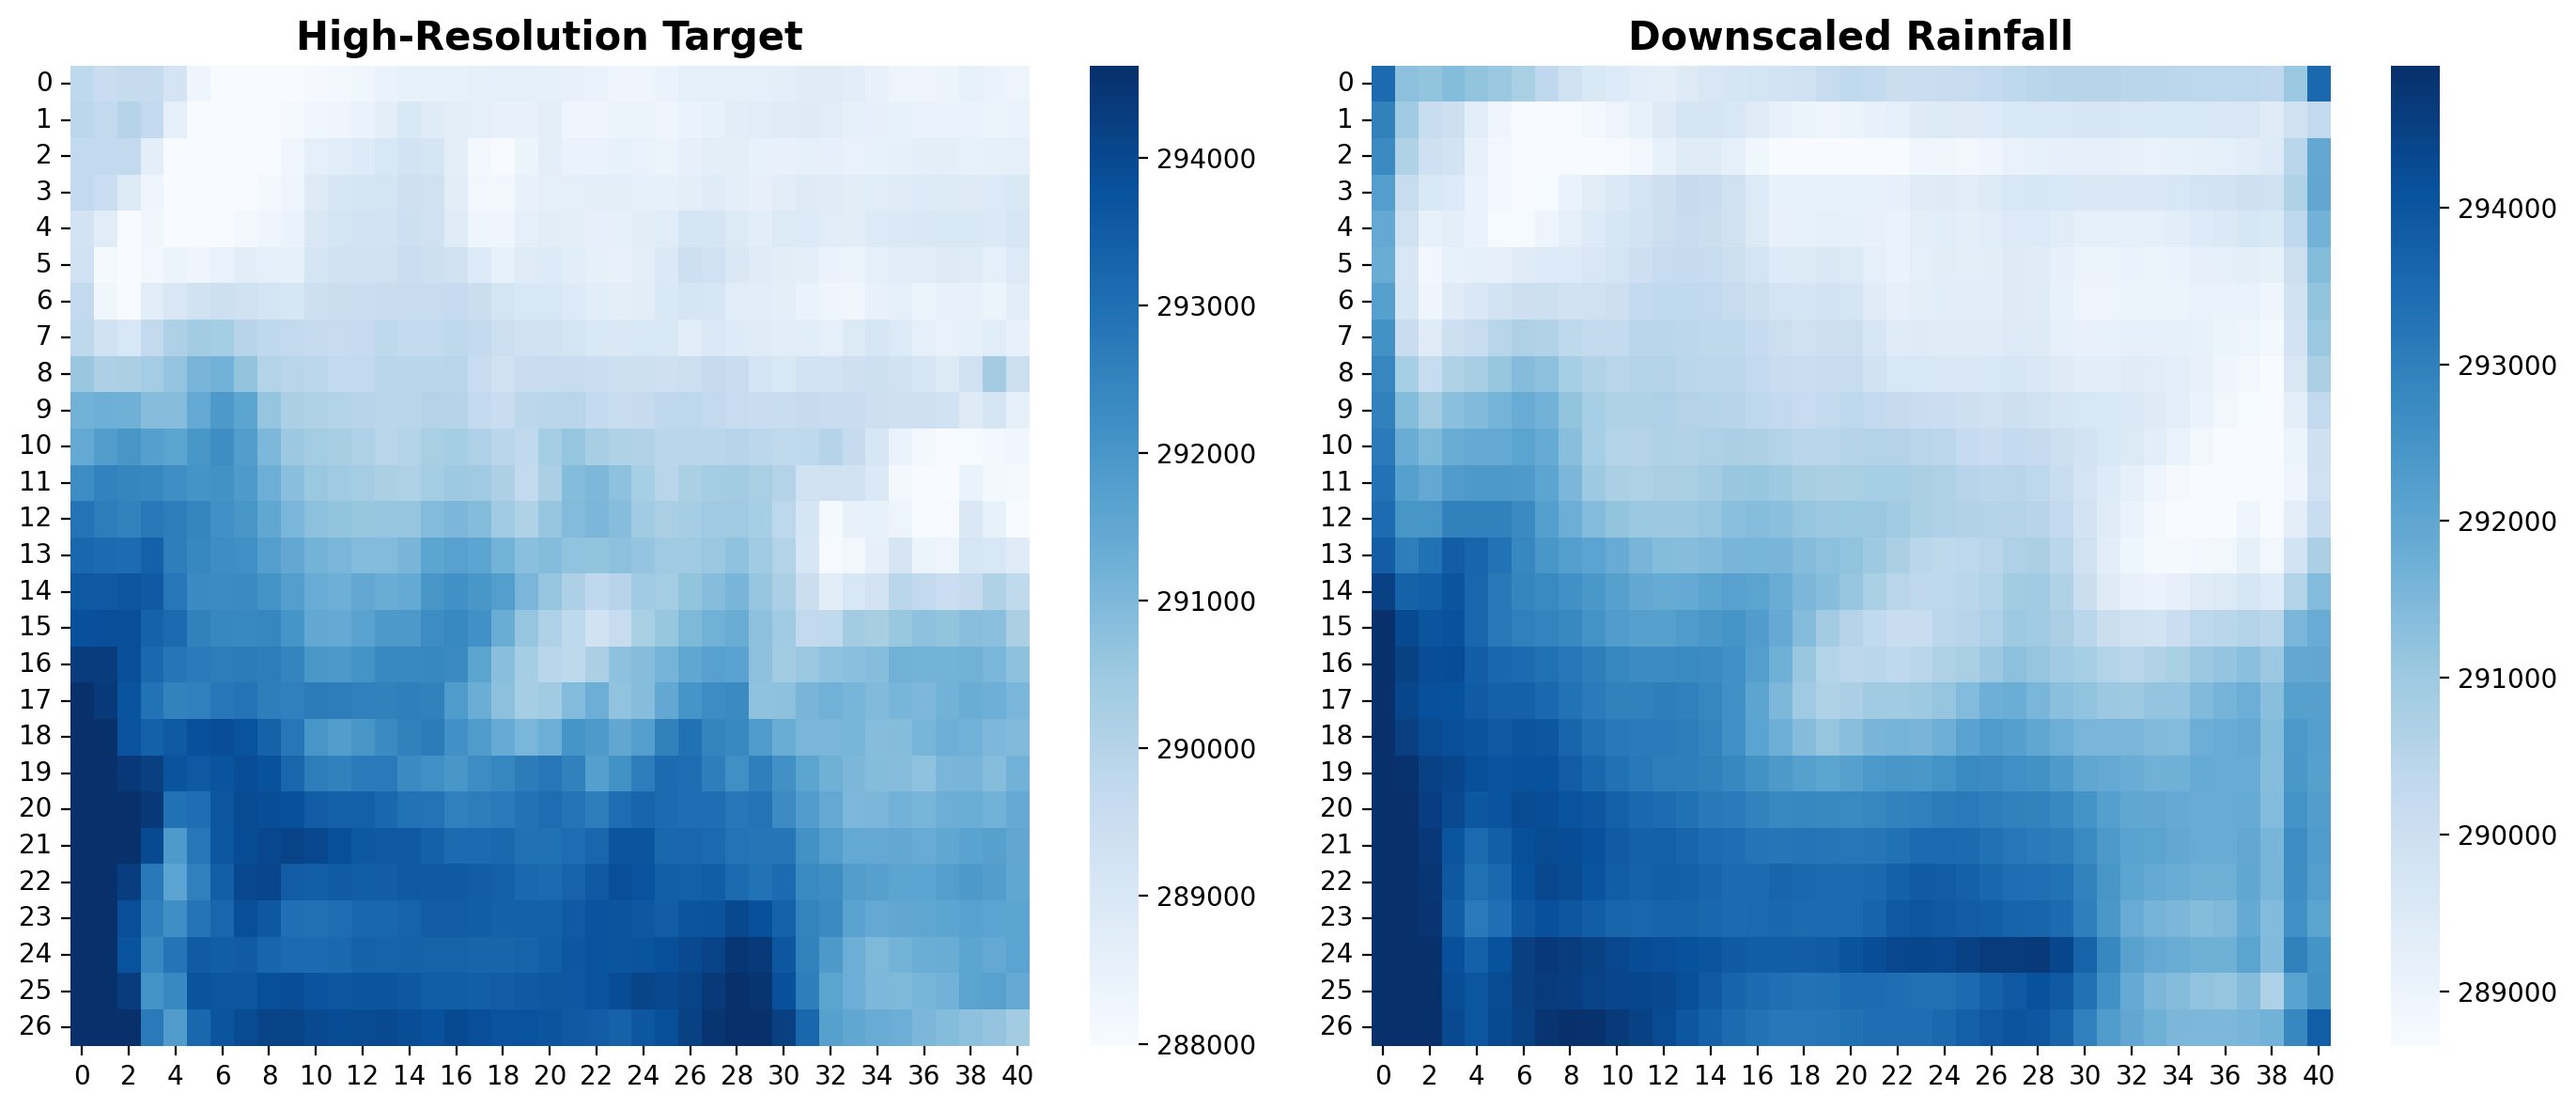

In [ ]:
def visualize_predictions(model, data_loader, high_res_mean, high_res_std):
    model.eval()
    with torch.no_grad():
        for low_res_batch, high_res_batch in data_loader:
            low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)
            output = model(low_res_batch)
            break

    # Denormalize the output and target
    denormalized_output = (output * high_res_std) + high_res_mean
    denormalized_output = denormalized_output.squeeze(1)  # Squeeze removes dimensions of size 1

    denormalized_target = (high_res_batch[:, -1, 0] * high_res_std) + high_res_mean

    print(f"Shape of denormalized_output: {denormalized_output.shape}")
    print(f"Shape of denormalized_target: {denormalized_target.shape}")

    N=15
    # Plotting
    plt.figure(figsize=(14, 6),dpi=200)

    # High-Resolution Target
    plt.subplot(1, 2, 1)
    #plt.imshow(denormalized_target[N].cpu(),cmap='Blues')
    sns.heatmap(denormalized_target[N].cpu(),robust=True,cmap='Blues')
    #sns.colorbar(label='High-Res Value', extend='both',aspect=25,fraction=0.045,shrink=0.70)
    plt.title("High-Resolution Target", size=15, weight='bold')

    # Model Prediction
    plt.subplot(1, 2, 2)
    #plt.imshow(denormalized_output[N, 0].cpu(),cmap='Blues')
    sns.heatmap(denormalized_output[N].cpu(),robust=True,cmap='Blues')
    #plt.colorbar(label='Predicted Value', extend='both',aspect=25,fraction=0.045,shrink=0.70)
    plt.title("Downscaled Rainfall", size=15, weight='bold')

    plt.tight_layout()
    plt.show()
    return denormalized_output,denormalized_target

X1,X2=visualize_predictions(trained_model, test_loader, high_res_mean, high_res_std)

### **Prediction_Plots**

In [ ]:
# Assume observed and predicted have shape [time, lat, lon]
observed = X2.cpu().numpy()
predicted =X1.cpu().numpy()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imageio
import os

In [ ]:
os.chdir('/content/drive/MyDrive/03_Downscaling_Work/Plots/')

In [ ]:
for t in range(16):
  plt.figure(figsize=(14, 6),dpi=300)

  # You can customize this plot to show both observed and predicted data
  # For example, create two heatmaps for each time step (you can adjust based on your needs)
  ax=plt.subplot(1, 2, 1)
  sns.heatmap(observed [t], robust=True,cmap='coolwarm', cbar_kws={'label': 'Observed'})
  plt.title("High-Resolution Observed Temperature   "+f'Time:{t+1}',fontsize=14,weight='bold')


  plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
  plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

  # Add color bar label
  cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
  cbar.set_label('Observed Temperature $(k)$', fontsize=12,weight='bold')
  plt.ylabel("Latitude", fontsize=12,weight='bold')
  plt.xlabel("Longitude", fontsize=12,weight='bold')


  ax=plt.subplot(1, 2, 2)
  sns.heatmap(predicted[t],robust=True, cmap='coolwarm', cbar=True)
  plt.title("Downscaled Temperature",fontsize=14,weight='bold')

  # Add color bar label
  cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
  cbar.set_label('Predicted Temperature $(k)$', fontsize=12,weight='bold')

  plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
  plt.yticks(ticks=np.arange(0, 27, 4))
  plt.xlabel("Longitude", fontsize=12,weight='bold')

  plt.tight_layout()
  # #--------------Save the plot as an image---------------------

  # image_path = f'gif_R_images/frame_{t}.png'
  # # plt.savefig(image_path)
  # # plt.close()

  image_dir = '/content/drive/MyDrive/03_Downscaling_Work/Plots/'
  if not os.path.exists(image_dir):
      os.makedirs(image_dir)

  # ... (rest of your plotting code) ...

  image_path = f'{image_dir}/T_frame_{t}.png'
  plt.savefig(image_path)
  plt.close()

In [ ]:
# Create the GIF using imageio
images = []
for t in range(16):
    image_path = f'T_frame_{t}.png'
    images.append(imageio.imread(image_path))

In [ ]:
# Save the images as a GIF
imageio.mimsave('observed_vs_predicted_Temp_Final.gif', images, duration=500)  # duration controls the speed

print("GIF created successfully!")

## **Perfromance_Matrices**

In [ ]:
Lat1=['26°','25°','24°','23°','22°','21°','20°']
Lon1=['74°','76°','78°','80°','82°']
#--------------------------RMSE---------------------------------
rmse_grid = np.sqrt(np.mean((predicted - observed) ** 2, axis=0))

#------------------------Bias---------------------------------------------
bias_grid = np.mean(observed - predicted, axis=0)
# ---------------------------NSE------------------------------
nse_grid = 1 - np.sum((observed - predicted) ** 2, axis=0) / np.sum((observed - np.mean(observed, axis=0)) ** 2, axis=0)



#-----------------Corr--------------------------------------

def calculate_correlation_vectorized(observed, predicted):
    # Subtract mean (axis=0 means mean over time)
    obs_mean = np.mean(observed, axis=0)
    pred_mean = np.mean(predicted, axis=0)

    # Compute the numerator: sum of (o - mean_o) * (p - mean_p)
    numerator = np.sum((observed - obs_mean) * (predicted - pred_mean), axis=0)

    # Compute the denominator: sqrt(sum((o - mean_o)^2) * sum((p - mean_p)^2))
    obs_sq_sum = np.sum((observed - obs_mean)**2, axis=0)
    pred_sq_sum = np.sum((predicted - pred_mean)**2, axis=0)

    denominator = np.sqrt(obs_sq_sum * pred_sq_sum)

    # Calculate the correlation (avoid division by zero)
    correlation_grid = np.where(denominator != 0, numerator / denominator, 0)

    return correlation_grid

# Calculate correlation at each grid point
correlation_grid = calculate_correlation_vectorized(observed, predicted)

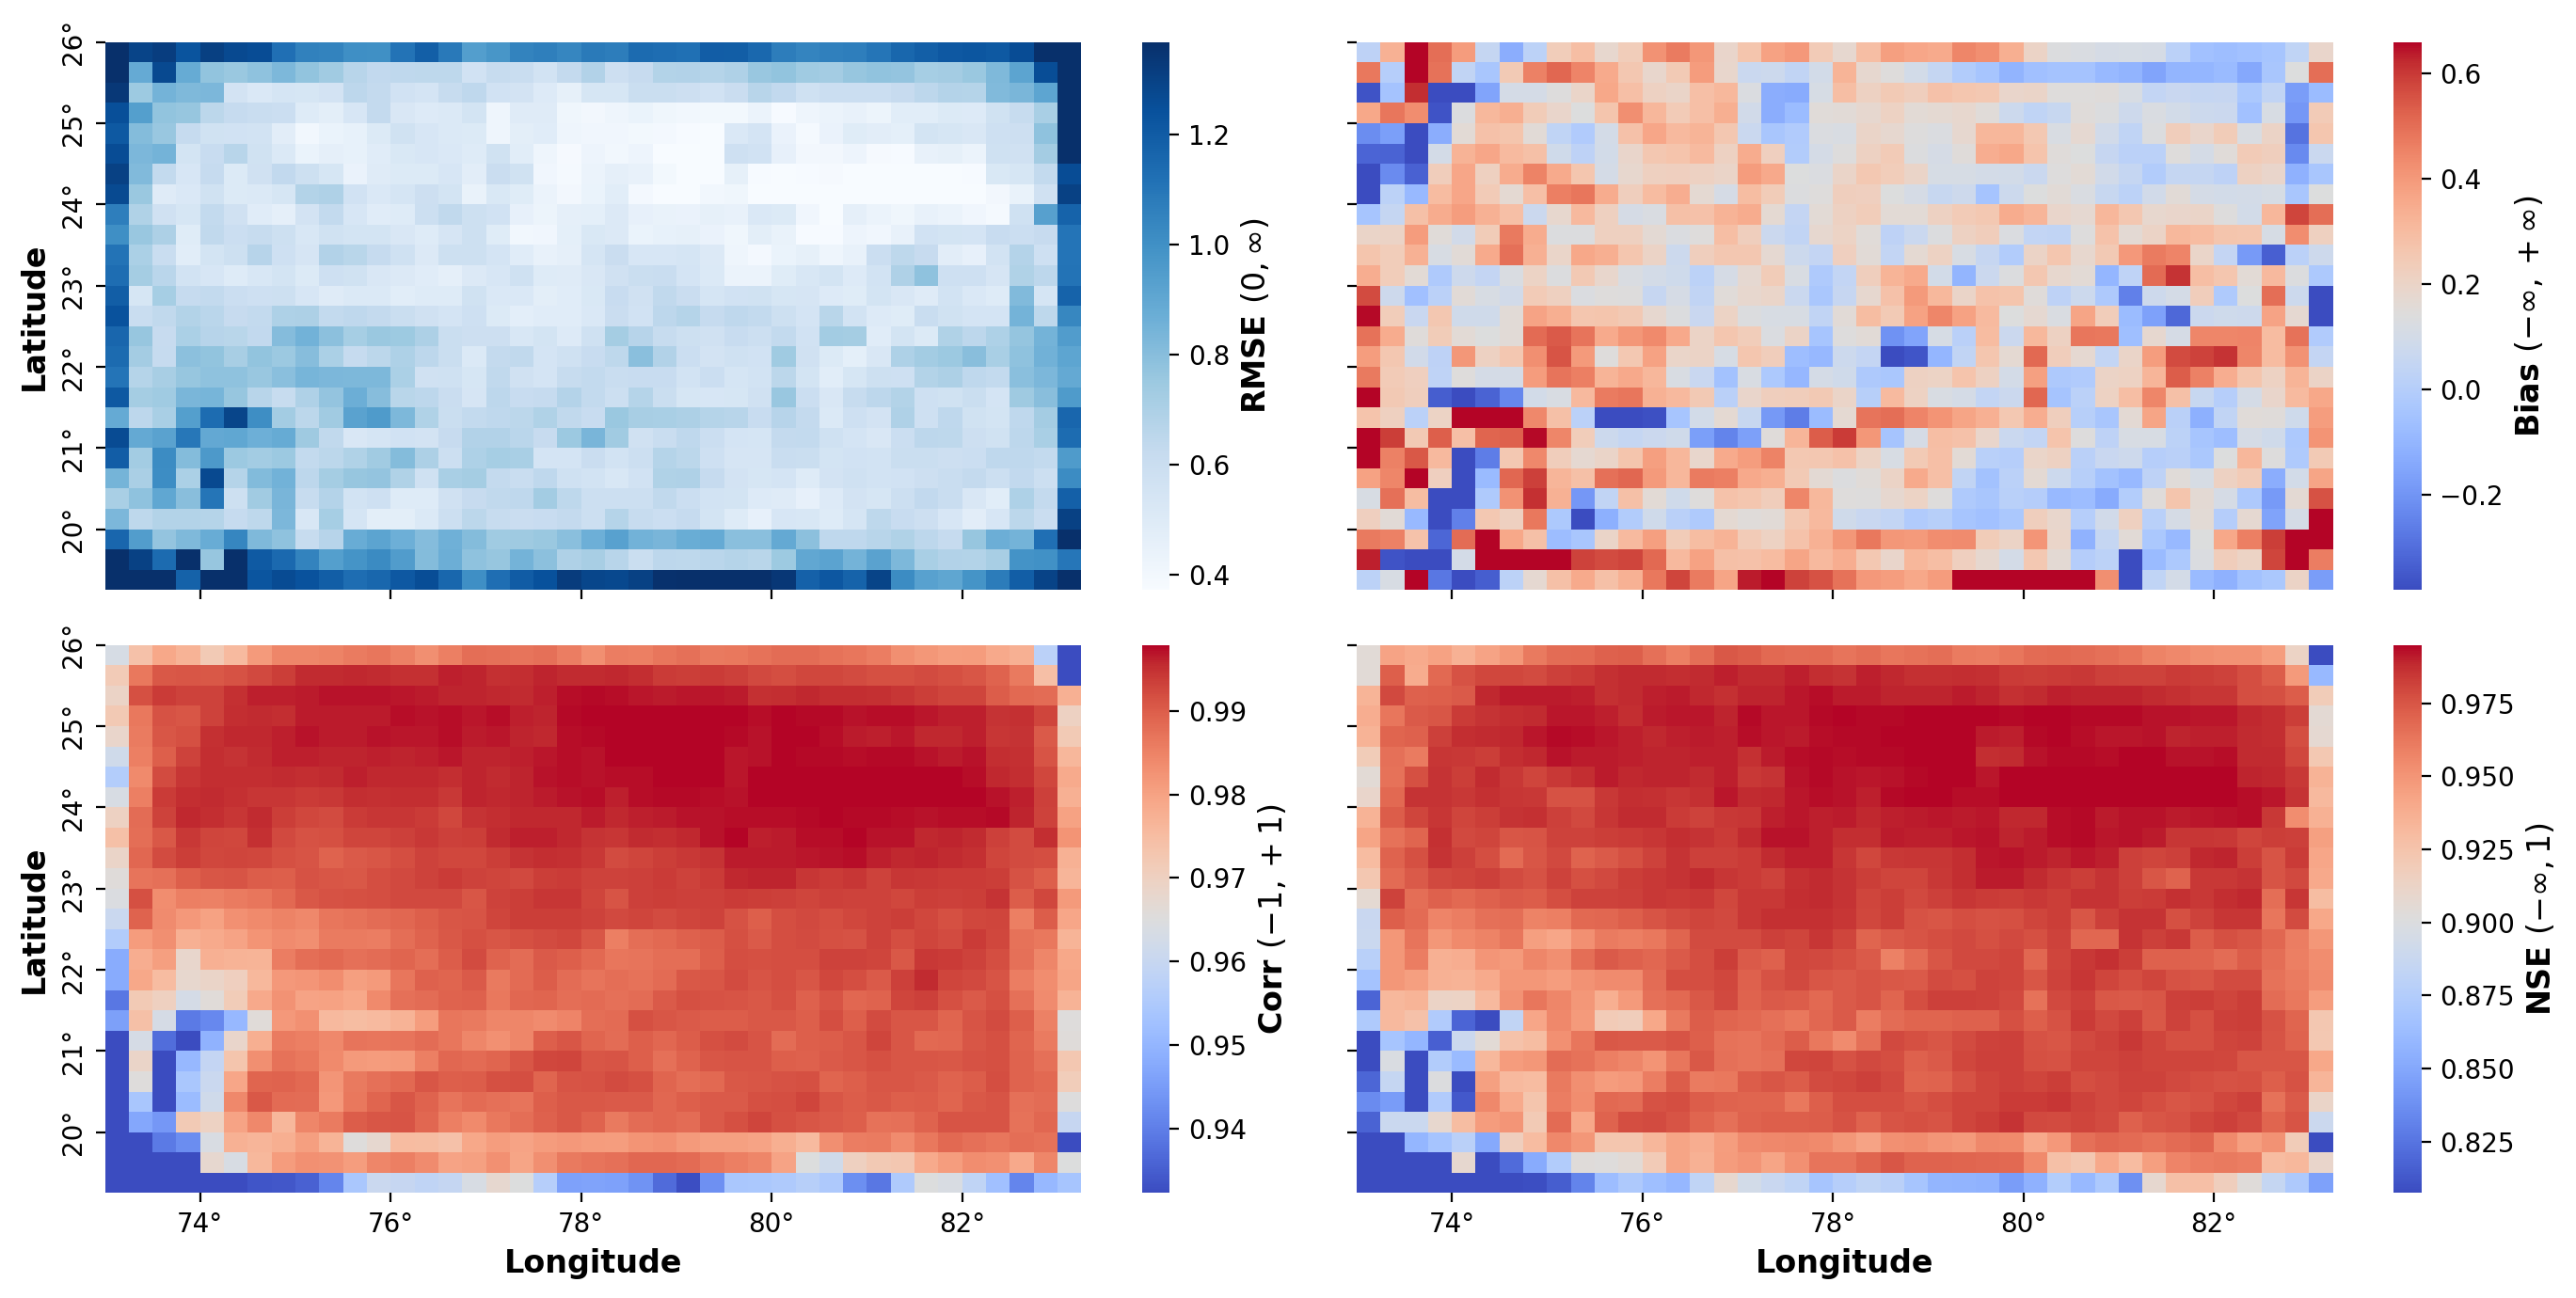

In [ ]:
#------------------------------ERROR BASED--------------------------------------------

plt.figure(figsize=(14,7),dpi=200)
ax=plt.subplot(2, 2, 1)
sns.heatmap(rmse_grid, robust=True, cmap='Blues')
# plt.title("RMSE Heatmap", fontsize=14, weight='bold')
plt.ylabel("Latitude", fontsize=12,weight='bold')


plt.xticks(ticks=np.arange(4, 41,8))
plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('RMSE $(0 ,\infty)$', fontsize=12,weight='bold')  # Set the label of the colorbar


# Plot NSE
ax=plt.subplot(2, 2, 2)
sns.heatmap(bias_grid, robust=True, cmap='coolwarm', annot=False, fmt=".2f", cbar=True)



plt.xticks(ticks=np.arange(4, 41,8))
plt.yticks(ticks=np.arange(0, 27, 4))

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap

cbar.set_label('Bias $(-\infty , +\infty)$', fontsize=12,weight='bold')  # Set the label of the colorbar
#----------------------------CORRELATION bASED--------------------------------------------------------------


# Plot NSE
ax=plt.subplot(2, 2, 3)
sns.heatmap(correlation_grid, robust=True, cmap='coolwarm')

plt.xlabel("Longitude", fontsize=12,weight='bold')
plt.ylabel("Latitude", fontsize=12,weight='bold')

plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('Corr $(-1 , +1)$', fontsize=12,weight='bold')  # Set the label of the colorbar

# Plot NSE
ax=plt.subplot(2, 2, 4)
sns.heatmap(nse_grid, robust=True, cmap='coolwarm')

plt.xlabel("Longitude", fontsize=12,weight='bold')



plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)  # x-ticks: every 5th tick
plt.yticks(ticks=np.arange(0, 27, 4), rotation=0)  # y-ticks: every 5th tick

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('NSE', fontsize=12,weight='bold')  # Set the label of the colorbar
cbar.set_label('NSE $(-\infty , 1)$', fontsize=12,weight='bold')  # Set the label of the colorbar
plt.tight_layout()
plt.show()

# **Downscaling of Rainfall**

## **Data loading and Stacking**

In [ ]:
# Load upscaled and original datasets
Input_data = xr.open_dataset('Interpolated_from_0.5_0.25_to_fine.nc') # 0.5 degree
Input_dataX=Input_data.sel(lat=slice(26,19.5),lon=slice(73,83))
Input_dataX=Input_dataX.sel(time=data["time"].dt.month.isin([6, 7, 8, 9]))

Target_data = xr.open_dataset('Input_downscaling_data_Central_India_1940_2023.nc') # 0.25 degree
Target_dataX=Target_data.sel(lat=slice(26,19.5),lon=slice(73,83))
Target_dataX=Target_dataX.sel(time=data["time"].dt.month.isin([6, 7, 8, 9]))



X_variables = ['MSLP', 'Specific_Humidity_850', 'Specific_Humidity_500', 'Air_Temperature_2m', 'Air_Temperature_850', 'Zonal_Wind_850', 'Meridional_Wind_850', 'Vertical_Wind_850', 'Geopotential_Height_850','Total_Precipitation']

target_variable = 'Total_Precipitation'


#---------------------
# Extract the data for each variable
extracted_data = [Input_dataX [var].values for var in X_variables]

# Stack the variables along the last axis (this creates an array of shape (time, lat, lon, num_variables))
stacked_data = np.stack(extracted_data, axis=-1)

# Reorder the axes to match the desired shape: [time, variable, lat, lon]
reformatted_data = np.moveaxis(stacked_data, (0, 1, 2, 3), (0, 2, 3, 1))
Input_tensor = torch.tensor(reformatted_data, dtype=torch.float32)
print(f"PyTorch Tensor shape: {Input_tensor.shape}")

#------------------------------------------------------------------------------------------------------------

extracted_data = Target_dataX[target_variable ].values  # Extract the values for the variable
# Transpose the dimensions to [lat, lon, time]
transposed_data = np.transpose(extracted_data, (0,1,2))
# Add a new dimension for the variable, resulting in [lat, lon, time, variables]
reshaped_data = np.expand_dims(transposed_data, axis=1)


# Convert to PyTorch tensor
Target_tensor = torch.tensor(reshaped_data, dtype=torch.float32)

# Verify the tensor shape
print(f"Tensor shape: {Target_tensor.shape}")  # Should be [47, 31, 1008, 1]

In [ ]:
# Data Preparation
# -------------------
def prepare_data(low_res_data, high_res_data, time_steps, batch_size):
    """
    Prepares normalized data for training, validation, and testing.
    """
    # Compute mean and std for each variable in the low-res dataset
    means = low_res_data.mean(axis=(0, 2, 3))
    stds = low_res_data.std(axis=(0, 2, 3))

    # Normalize low-res data
    low_res_data = (low_res_data - means[None, :, None, None]) / stds[None, :, None, None]

    # Normalize high-res data (if required)
    high_res_mean = high_res_data.mean()
    high_res_std = high_res_data.std()
    high_res_data = (high_res_data - high_res_mean) / high_res_std

    # Validate divisibility by time steps
    num_samples = low_res_data.shape[0]
    if num_samples % time_steps != 0:
        num_samples = num_samples // time_steps * time_steps  # Truncate extra samples

    # Reshape for temporal modeling
    low_res_data = low_res_data[:num_samples].view(-1, time_steps, 10, 27,41)
    high_res_data = high_res_data[:num_samples].view(-1, time_steps, 1, 27,41)

    # Create dataset
    dataset = TensorDataset(low_res_data, high_res_data)

    # Split into train, validation, and test sets
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, means, stds, high_res_mean, high_res_std

## **Rainfall ConvLSTM**

In [ ]:
# -------------------
# ConvLSTM Model
# -------------------
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm_cells = nn.ModuleList([
            nn.Conv2d(input_dim if i == 0 else hidden_dim,
                      hidden_dim,
                      kernel_size=kernel_size,
                      padding=kernel_size // 2)
            for i in range(num_layers)
        ])

        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        batch_size, time_steps, channels, height, width = x.shape
        h, c = [torch.zeros(batch_size, self.hidden_dim, height, width).to(x.device) for _ in range(2)]

        for t in range(time_steps):
            cur_input = x[:, t]
            for i, lstm_cell in enumerate(self.lstm_cells):
                h_next = torch.tanh(lstm_cell(cur_input)) + c
                h_next = self.dropout(h_next)  # Dropout
                c = h_next  # Update cell state
                cur_input = h_next

        # Output layer for the last time step
        output = self.conv_out(cur_input)
        return output

# -------------------
# Loss Functions
# -------------------
def combined_loss(output, target, alpha=0.8):
    """
    Combines MSE Loss and SSIM Loss.
    """
    mse_loss = nn.MSELoss()(output, target)
    ssim_loss = 1 - ssim(output, target, data_range=1.0)
    return alpha * mse_loss + (1 - alpha) * ssim_loss

# -------------------
# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs):
    model.train()

    # Initialize lists to store losses
    L1 = []  # To store training loss for each epoch
    L2 = []  # To store validation loss for each epoch

    for epoch in range(epochs):
        train_loss = 0.0
        for low_res_batch, high_res_batch in train_loader:
            low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(low_res_batch)

            # Compute loss
            target = high_res_batch[:, -1, :, :, :]
            loss = combined_loss(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average training loss for the epoch
        Ls_train = train_loss / len(train_loader)
        L1.append(Ls_train)

        # Scheduler step
        scheduler.step()

        # Validation
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for low_res_batch, high_res_batch in val_loader:
                low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)
                output = model(low_res_batch)
                target = high_res_batch[:, -1, :, :, :]
                val_loss += combined_loss(output, target).item()

        # Calculate average validation loss for the epoch
        Ls_val = val_loss / len(val_loader)
        L2.append(Ls_val)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {Ls_train:.4f}, Val Loss: {Ls_val:.4f}")

    return model, L1, L2


low_res_data=Input_tensor
high_res_data=Target_tensor
# Main
# -------------------

if __name__ == "__main__":
    # Example synthetic data
    low_res_data = Input_tensor
    high_res_data = Target_tensor
#--------------------Parameters---------------------------------------
    time_steps = 2
    batch_size = 16
    epochs = 50
    learning_rate = 0.001

    # Prepare data
    train_loader, val_loader, test_loader,means, stds, high_res_mean, high_res_std  = prepare_data(low_res_data, high_res_data, time_steps, batch_size) #----------------------------------

    # Model
    model = ConvLSTM(input_dim=10, hidden_dim=64, kernel_size=3, num_layers=3).to(device)

    # Optimizer and Scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Train the model
    trained_model,Ls,Lv = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs)

In [ ]:
plt.figure(figsize=(12, 8),dpi=200)
plt.plot(Ls[1:], label='Training Loss')
plt.plot(Lv[1:], label='Validation Loss')
plt.xlabel('Epoch',fontsize='14',weight='bold')
plt.ylabel('Loss',fontsize='14',weight='bold')
# plt.title('Training and Validation Loss',fontsize='20',weight='bold',)
plt.grid(color='gray',linestyle='--')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Get the current axes
ax = plt.gca()

# Set the font weight of the tick labels to bold
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.show()

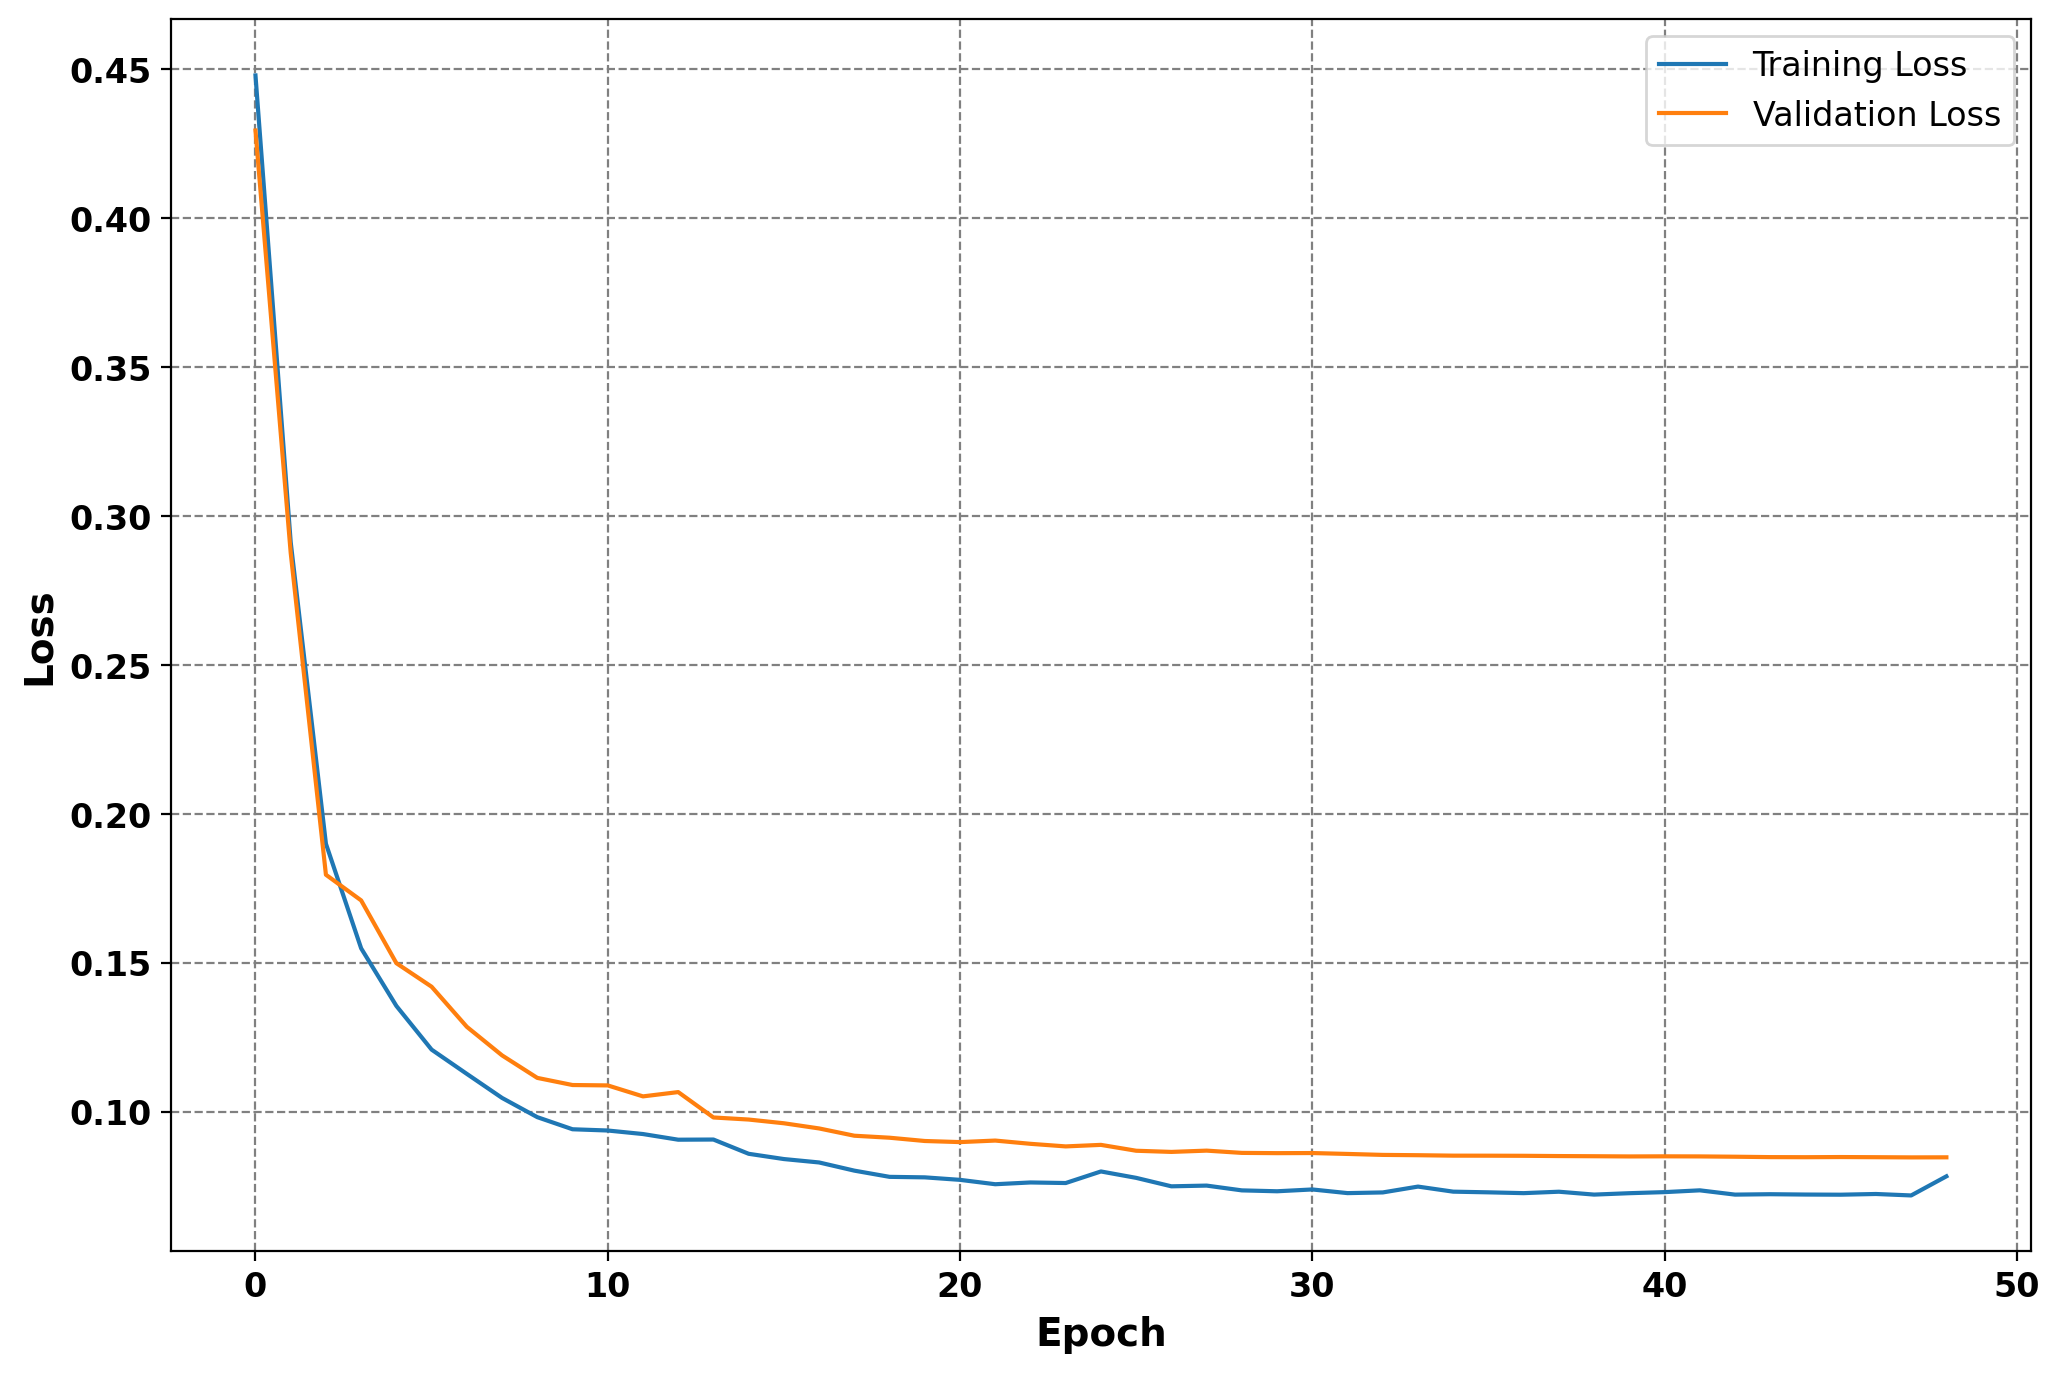

## **Visualization of Testing Data**

In [ ]:
def visualize_predictions(model, data_loader, high_res_mean, high_res_std):
    model.eval()
    with torch.no_grad():
        for low_res_batch, high_res_batch in data_loader:
            low_res_batch, high_res_batch = low_res_batch.to(device), high_res_batch.to(device)
            output = model(low_res_batch)
            break

    # Denormalize the output and target
    denormalized_output = (output * high_res_std) + high_res_mean
    denormalized_output = denormalized_output.squeeze(1)  # Squeeze removes dimensions of size 1

    denormalized_target = (high_res_batch[:, -1, 0] * high_res_std) + high_res_mean

    print(f"Shape of denormalized_output: {denormalized_output.shape}")
    print(f"Shape of denormalized_target: {denormalized_target.shape}")

    N=15
    # Plotting
    plt.figure(figsize=(14, 6),dpi=200)

    # High-Resolution Target
    plt.subplot(1, 2, 1)
    #plt.imshow(denormalized_target[N].cpu(),cmap='Blues')
    sns.heatmap(1000*denormalized_target[N].cpu(),robust=True,cmap='Blues')
    #sns.colorbar(label='High-Res Value', extend='both',aspect=25,fraction=0.045,shrink=0.70)
    plt.title("High-Resolution Target", size=15, weight='bold')

    # Model Prediction
    plt.subplot(1, 2, 2)
    #plt.imshow(denormalized_output[N, 0].cpu(),cmap='Blues')
    sns.heatmap(1000*denormalized_output[N].cpu(),robust=True,cmap='Blues')
    #plt.colorbar(label='Predicted Value', extend='both',aspect=25,fraction=0.045,shrink=0.70)
    plt.title("Downscaled Rainfall", size=15, weight='bold')

    plt.tight_layout()
    plt.show()
    return denormalized_output,denormalized_target

X1,X2=visualize_predictions(trained_model, test_loader, high_res_mean, high_res_std)

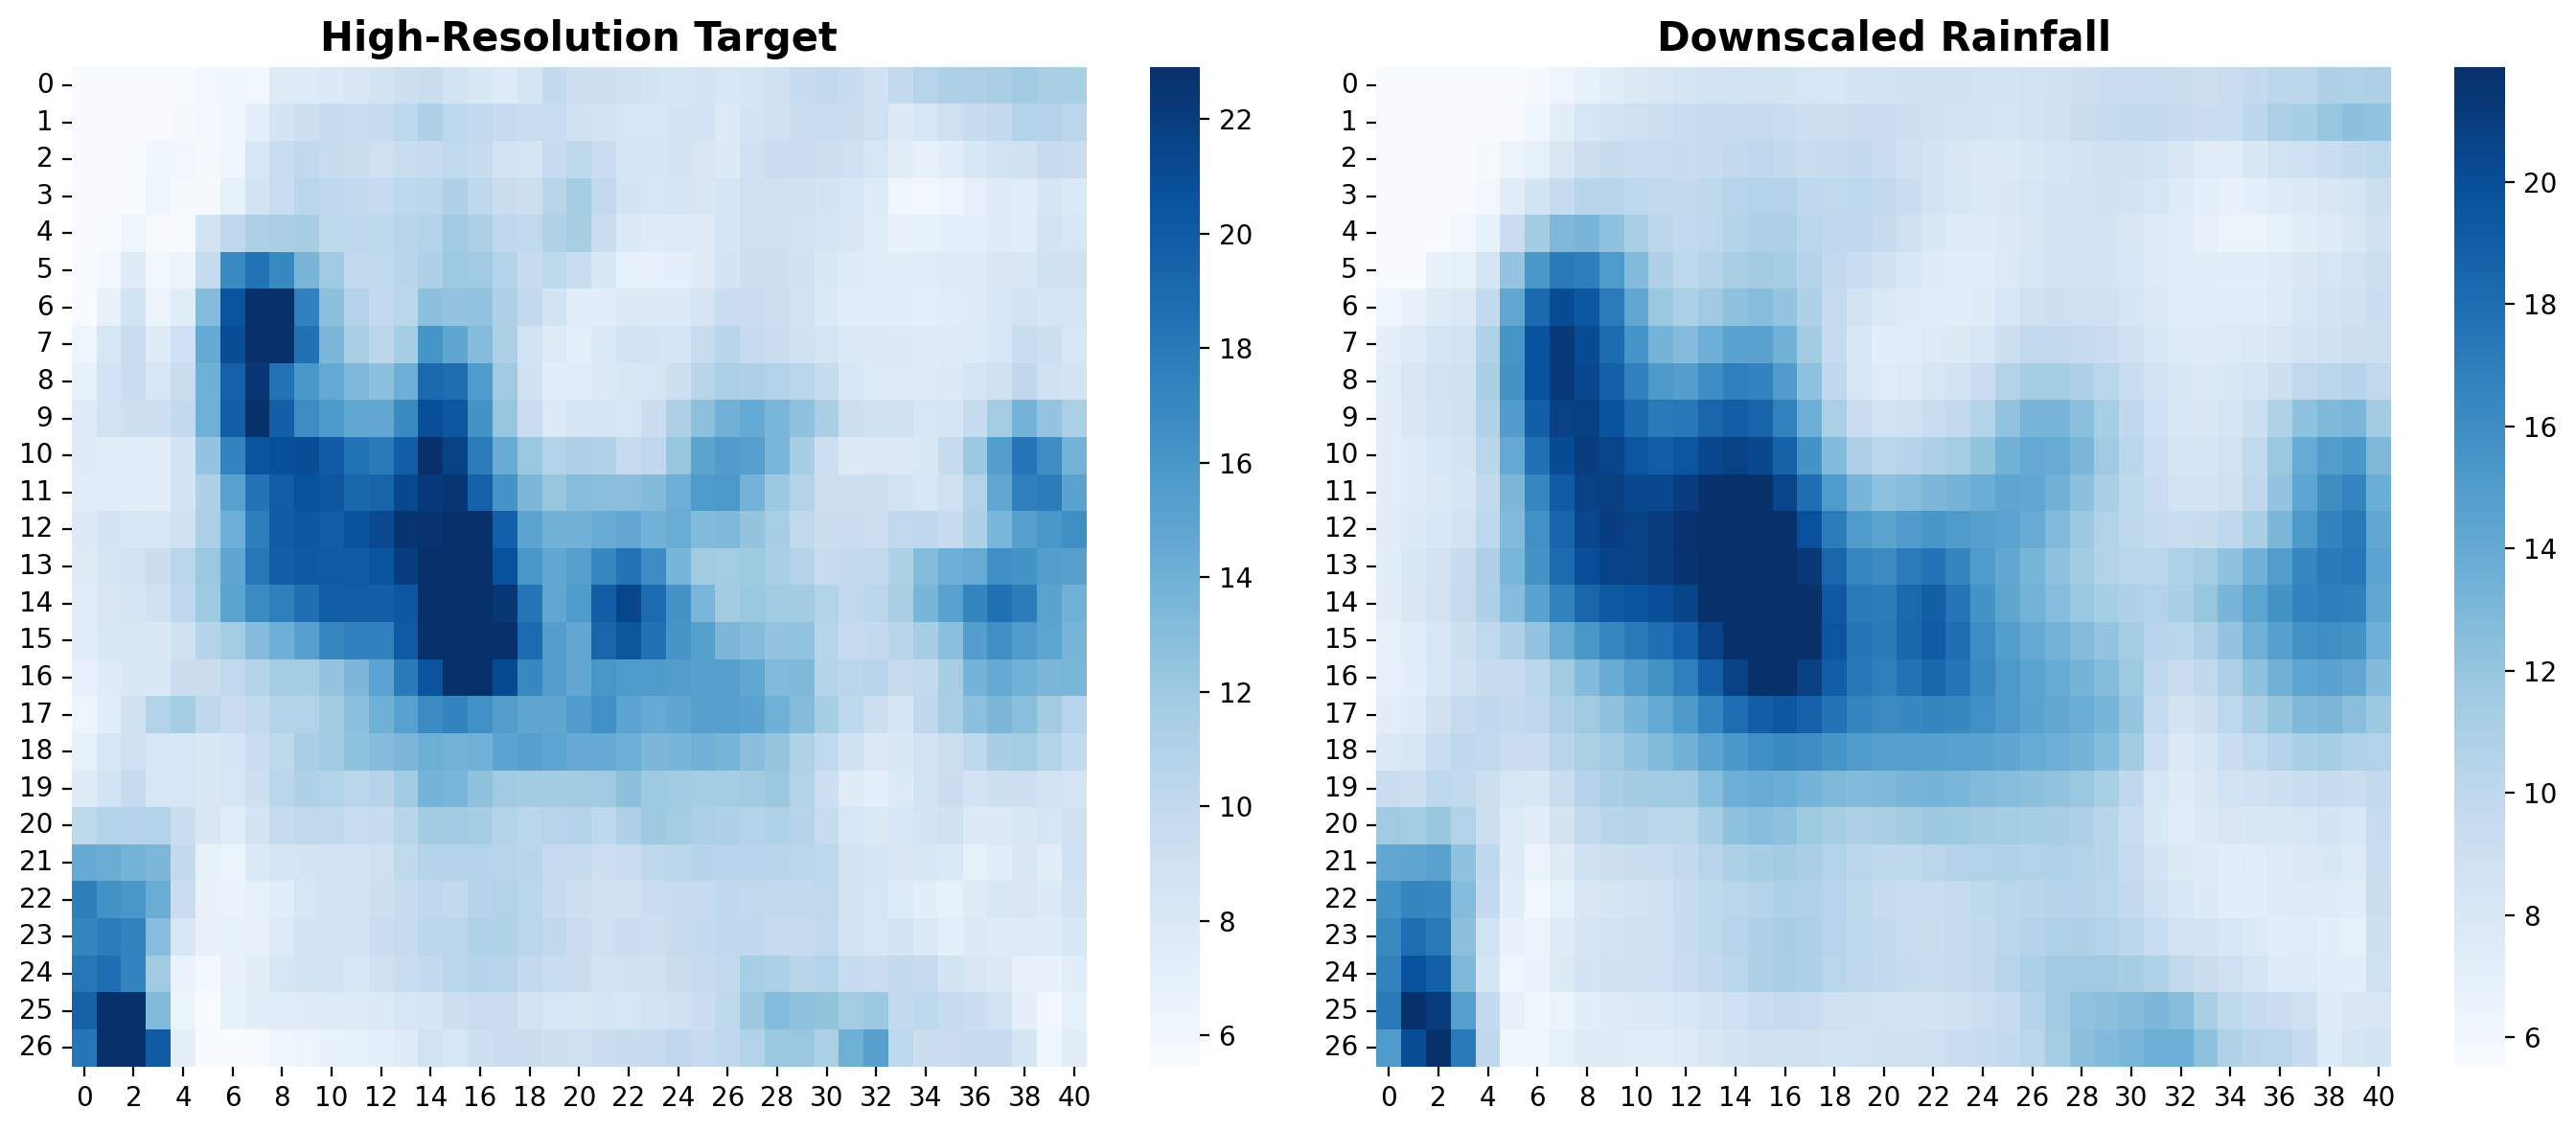

### **Prediction_Plots**

In [ ]:
# Assume observed and predicted have shape [time, lat, lon]
observed = 1000*X2.cpu().numpy()
predicted = 1000*X1.cpu().numpy()

In [ ]:
os.chdir('/content/drive/MyDrive/03_Downscaling_Work/Plots/')

In [ ]:

for t in range(16):
  plt.figure(figsize=(14, 6),dpi=300)

  # You can customize this plot to show both observed and predicted data
  # For example, create two heatmaps for each time step (you can adjust based on your needs)
  ax=plt.subplot(1, 2, 1)
  sns.heatmap(observed [t], robust=True,cmap='Blues', cbar_kws={'label': 'Observed'})
  plt.title("High-Resolution Observed Rainfall   "+f'Time:{t+1}',fontsize=14,weight='bold')


  plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
  plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

  # Add color bar label
  cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
  cbar.set_label('Observed rainfall $(mm/month)$', fontsize=12,weight='bold')
  plt.ylabel("Latitude", fontsize=12,weight='bold')
  plt.xlabel("Longitude", fontsize=12,weight='bold')


  ax=plt.subplot(1, 2, 2)
  sns.heatmap(predicted[t],robust=True, cmap='Blues', cbar=True)
  plt.title("Downscaled Rainfall",fontsize=14,weight='bold')

  # Add color bar label
  cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
  cbar.set_label('Predicted rainfall $(mm/month)$', fontsize=12,weight='bold')

  plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
  plt.yticks(ticks=np.arange(0, 27, 4))
  plt.xlabel("Longitude", fontsize=12,weight='bold')

  plt.tight_layout()
  # #--------------Save the plot as an image---------------------

  # image_path = f'gif_R_images/frame_{t}.png'
  # # plt.savefig(image_path)
  # # plt.close()

  image_dir = '/content/drive/MyDrive/03_Downscaling_Work/Plots/'
  if not os.path.exists(image_dir):
      os.makedirs(image_dir)

  # ... (rest of your plotting code) ...

  image_path = f'{image_dir}/R_frame_{t}.png'
  plt.savefig(image_path)
  plt.close()

In [ ]:
!ls

drive  sample_data


In [ ]:
# Create the GIF using imageio
images = []
for t in range(16):
    image_path = f'R_frame_{t}.png'
    images.append(imageio.imread(image_path))

In [ ]:
# Save the images as a GIF
imageio.mimsave('observed_vs_predicted_finalXX.gif', images, duration=500)  # duration controls the speed

print("GIF created successfully!")

## **Perfromance_Matrices**

In [ ]:
Lat1=['26°','25°','24°','23°','22°','21°','20°']
Lon1=['74°','76°','78°','80°','82°']
#--------------------------RMSE---------------------------------
rmse_grid = np.sqrt(np.mean((predicted - observed) ** 2, axis=0))

#------------------------Bias---------------------------------------------
bias_grid = np.mean(observed - predicted, axis=0)
# ---------------------------NSE------------------------------
nse_grid = 1 - np.sum((observed - predicted) ** 2, axis=0) / np.sum((observed - np.mean(observed, axis=0)) ** 2, axis=0)



#-----------------Corr--------------------------------------

def calculate_correlation_vectorized(observed, predicted):
    # Subtract mean (axis=0 means mean over time)
    obs_mean = np.mean(observed, axis=0)
    pred_mean = np.mean(predicted, axis=0)

    # Compute the numerator: sum of (o - mean_o) * (p - mean_p)
    numerator = np.sum((observed - obs_mean) * (predicted - pred_mean), axis=0)

    # Compute the denominator: sqrt(sum((o - mean_o)^2) * sum((p - mean_p)^2))
    obs_sq_sum = np.sum((observed - obs_mean)**2, axis=0)
    pred_sq_sum = np.sum((predicted - pred_mean)**2, axis=0)

    denominator = np.sqrt(obs_sq_sum * pred_sq_sum)

    # Calculate the correlation (avoid division by zero)
    correlation_grid = np.where(denominator != 0, numerator / denominator, 0)

    return correlation_grid

# Calculate correlation at each grid point
correlation_grid = calculate_correlation_vectorized(observed, predicted)

In [ ]:
#------------------------------ERROR BASED--------------------------------------------

plt.figure(figsize=(14,7),dpi=200)
ax=plt.subplot(2, 2, 1)
sns.heatmap(rmse_grid, robust=True, cmap='Blues')
# plt.title("RMSE Heatmap", fontsize=14, weight='bold')
plt.ylabel("Latitude", fontsize=12,weight='bold')


plt.xticks(ticks=np.arange(4, 41,8))
plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('RMSE $(0 ,\infty)$', fontsize=12,weight='bold')  # Set the label of the colorbar


# Plot NSE
ax=plt.subplot(2, 2, 2)
sns.heatmap(bias_grid, robust=True, cmap='coolwarm', annot=False, fmt=".2f", cbar=True)



plt.xticks(ticks=np.arange(4, 41,8))
plt.yticks(ticks=np.arange(0, 27, 4))

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap

cbar.set_label('Bias $(-\infty , +\infty)$', fontsize=12,weight='bold')  # Set the label of the colorbar
#----------------------------CORRELATION bASED--------------------------------------------------------------


# Plot NSE
ax=plt.subplot(2, 2, 3)
sns.heatmap(correlation_grid, robust=True, cmap='coolwarm')

plt.xlabel("Longitude", fontsize=12,weight='bold')
plt.ylabel("Latitude", fontsize=12,weight='bold')

plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)
plt.yticks(ticks=np.arange(0, 27, 4),labels=Lat1)

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('Corr $(-1 , +1)$', fontsize=12,weight='bold')  # Set the label of the colorbar

# Plot NSE
ax=plt.subplot(2, 2, 4)
sns.heatmap(nse_grid, robust=True, cmap='coolwarm')

plt.xlabel("Longitude", fontsize=12,weight='bold')



plt.xticks(ticks=np.arange(4, 41,8),labels=Lon1)  # x-ticks: every 5th tick
plt.yticks(ticks=np.arange(0, 27, 4), rotation=0)  # y-ticks: every 5th tick

# Add color bar label
cbar = ax.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.set_label('NSE', fontsize=12,weight='bold')  # Set the label of the colorbar
cbar.set_label('NSE $(-\infty , 1)$', fontsize=12,weight='bold')  # Set the label of the colorbar
plt.tight_layout()
plt.show()

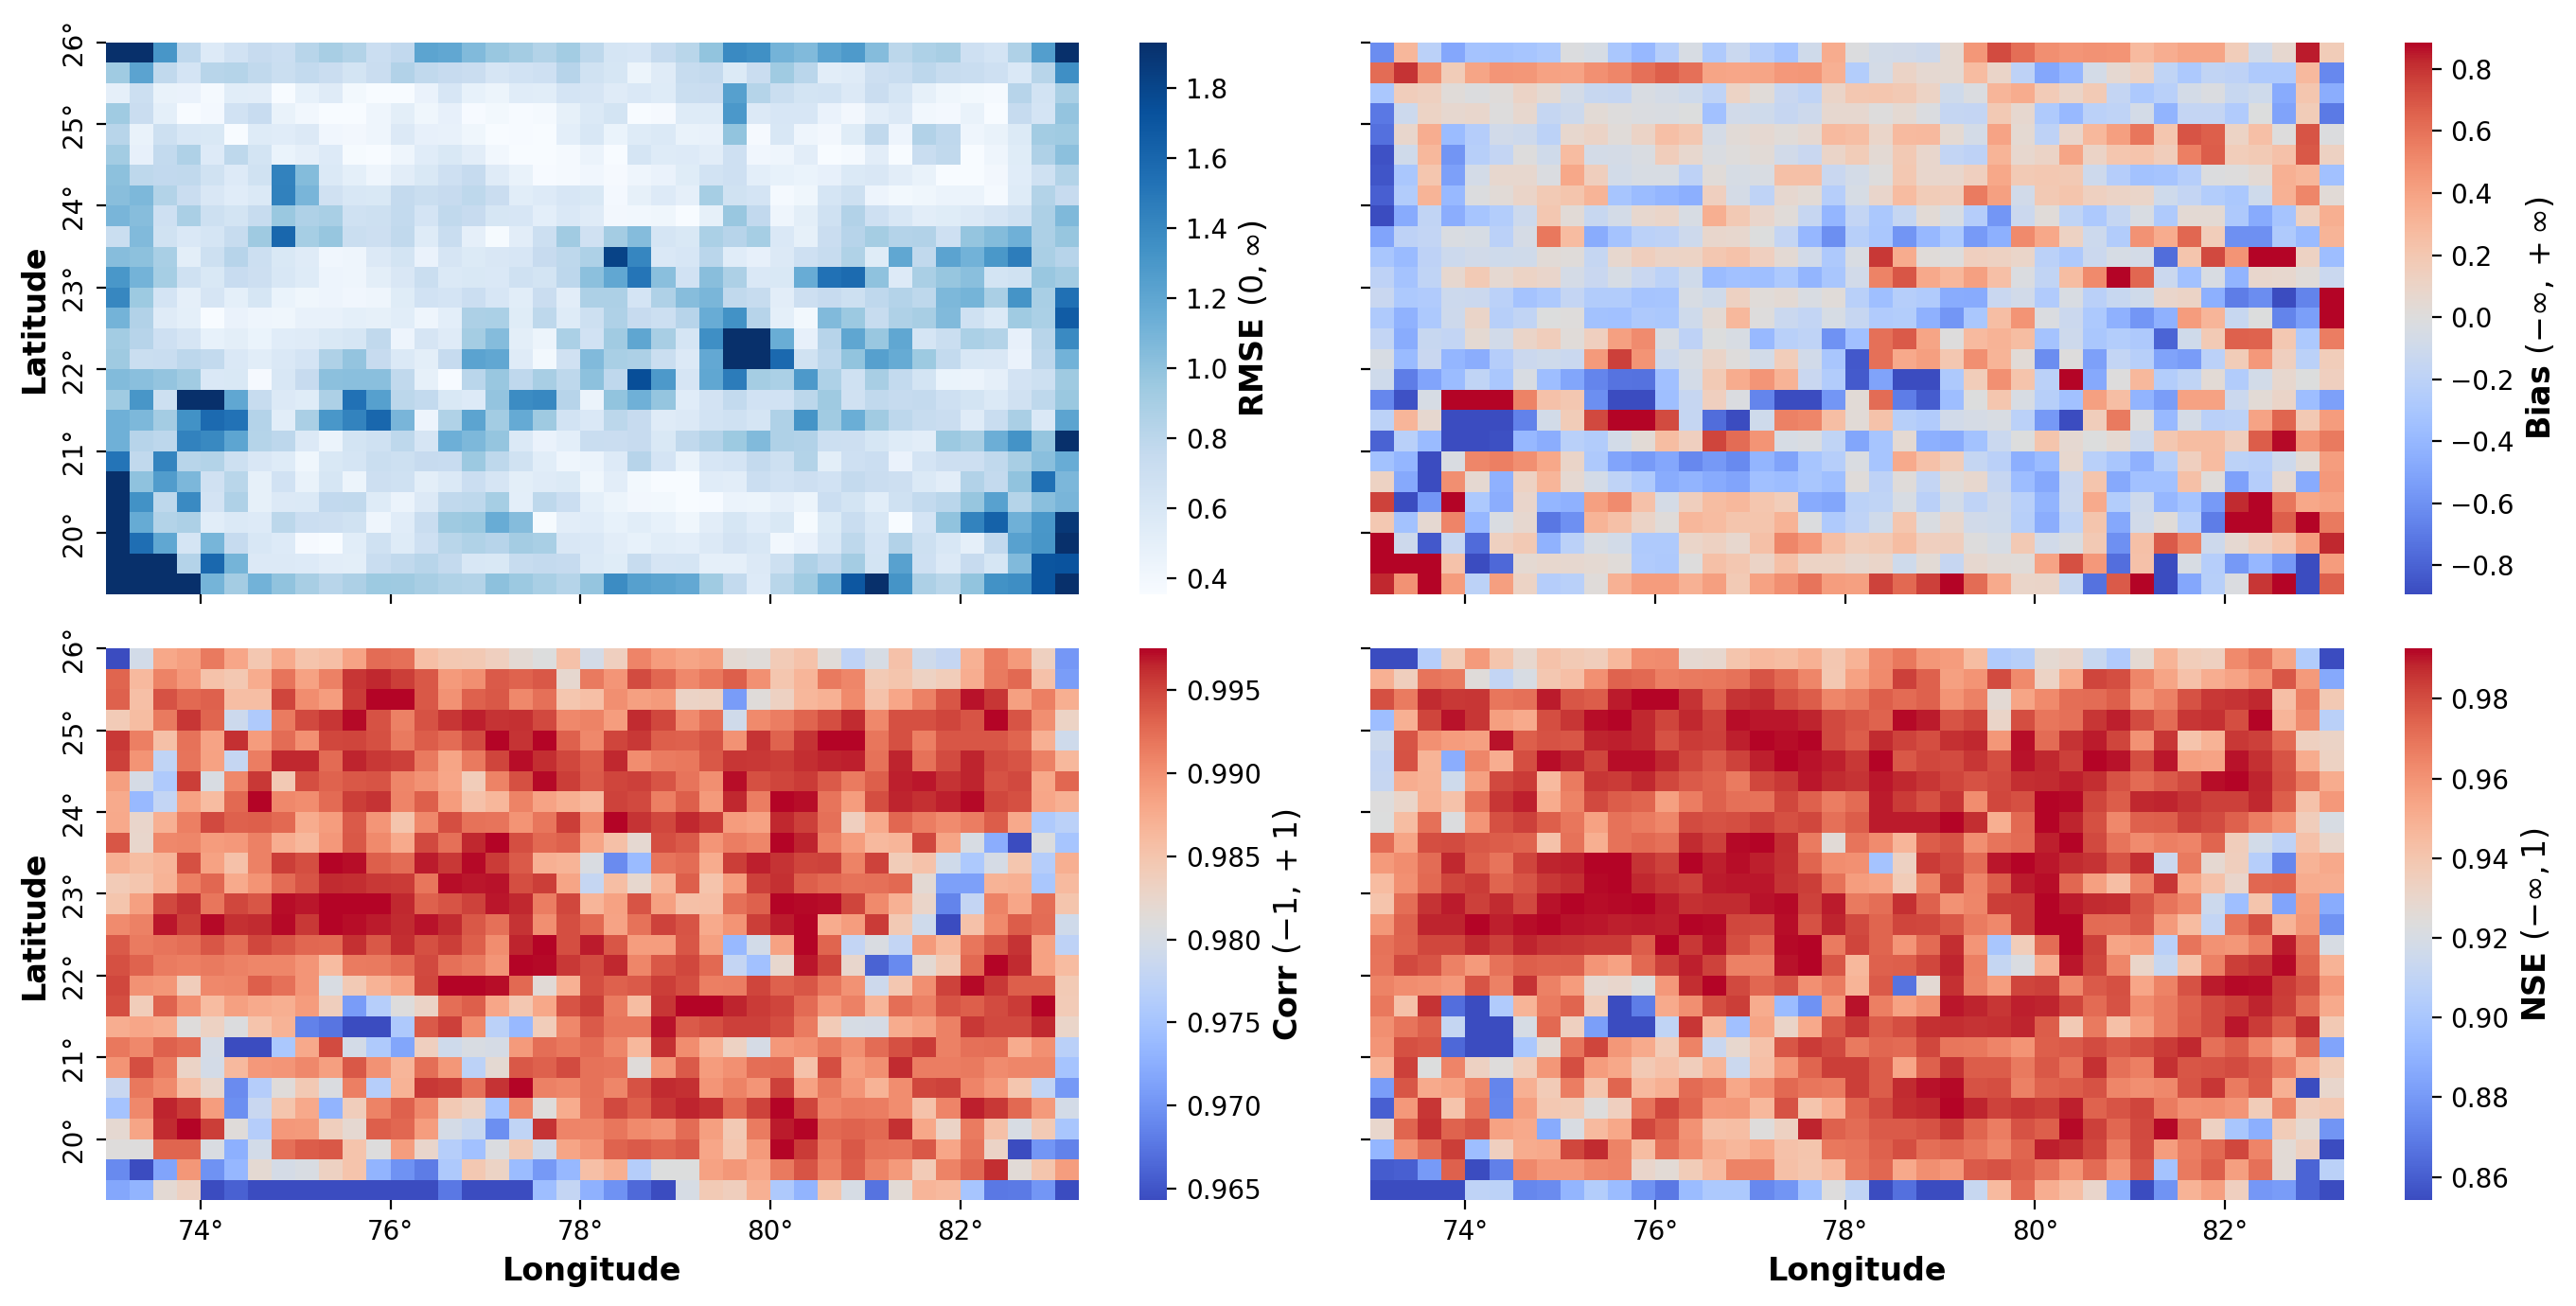